# Homework 4: Maximum Likelihood Estimate of Boltzmann’s Constant

The log-likelihood is the product of the probabilities according to the Poisson distribution:

\begin{equation*}
\ln \mathcal{L} = \prod_{i=1}^{4} p(n_i|\nu_i) = \prod_{i=1}^{4}\frac{\nu^{n_i}e^{-\nu}}{n_i!}
\end{equation*}

$\nu$ is the mean and $n$ the counts for each observation. To calculate $\nu_0$ and $k_B$, we minimize the function $-\ln \mathcal{L}$.

In [1]:
import scipy.optimize as opt
from scipy.special import loggamma as loggamma
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
z_obs = np.array([0, 6, 12, 18], dtype='float')
n_obs = np.array([1880, 940, 530, 305], dtype='int')

# Guess for nu_0 and k_b
guess = [1000, 1e-14] 

def poisson_prob(params, z, n, r=0.52, drho=0.063, g=980, temp=293):
    """
    Calculates -log of the Poisson distribution.
    Note that the factorial is approximated by
    the gamma function as gamma(n-1) = n!

    Parameters
    ----------
    params : list
        List of floats for the Boltzmann
        constant and constant nu
    z : list
        List of heights [um]
    n : list
        List of counts at each height
    r : float
        Radius of the droplets [um]
    drho : float
        Difference in density between water
        [g cm^-3]
    g : float
        Gravitational acceleration [cm s^-2]
    temp : float
        Temperature in Kelvin

    Returns
    -------
    Log of the Poisson probability 
    """
    nu_0, k_b = params

    num = 4 * np.pi * (r/1e4)**3 * drho * g * (z/1e4)
    denom = 3 * k_b * temp
    mean = num / denom

    return n * np.log(nu_0) - n * mean - nu_0 * np.exp(-mean) - loggamma(n+1)

def log_likelihood(params, height, count):
    """
    The negative log likelihood of N observations. 

    Parameters
    ----------
    params : list
        List of floats for the Boltzmann
        constant and constant nu
    height : list
        List of heights [um]
    count : list
        List of counts at each height

    Returns
    -------
    Negative log-likelihood
    """
    log_prob = 0
    for z, n in zip(height, count):
        log_prob += poisson_prob(params, z, n)

    return -log_prob

In [3]:
# Minimize to find nu_0 and k_b
def callbackF(data):
    # Print out minimizer progress with callback
    print(data)
    return None

guess = [1000, 1e-10]

ML_params = opt.minimize(log_likelihood, guess, args=(z_obs, n_obs), method='Nelder-Mead')
nu_est, kb_est = ML_params.x
print("Nu constant estimate: {:.3f}".format(nu_est))
print("Boltzmann constant estimate: {0:.3E}".format(kb_est))

Nu constant estimate: 1844.945
Boltzmann constant estimate: 1.199E-16


2D contour plot along with 68% confidence interval.

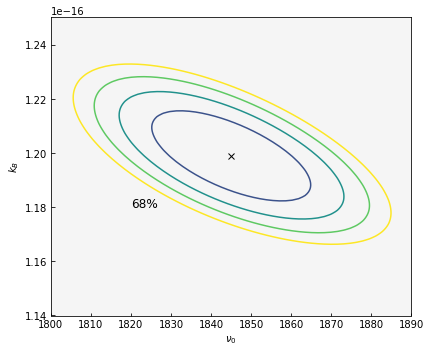

In [4]:
# Define grid of points over which to operate.
# NOTE: x and y are 2d arrays, this is required for plotting
x, y = np.meshgrid(np.linspace(1600, 2000, 250), np.linspace(1.1e-16, 1.25e-16, 250))

# Evaluate log-likelihood function at every point in the grid
z = np.zeros_like(x)

for i in range(z.shape[0]):
    for j in range(z.shape[1]):
        z[i][j] = log_likelihood([x[i][j], y[i][j]], z_obs, n_obs)

# Use the 1/2 rule to find the 68% confidence interval
conf68 = np.min(z) + 1/2

fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.plot(0, 0, 'x', color='k')
cs = ax.contour(x, y, z, levels=np.linspace(np.min(z), conf68, 5), cmap='viridis')
ax.plot(1.8449445e3, 1.1987025e-16, marker='x', color='k')
ax.clabel(cs, inline=True, fontsize=10)
ax.set(xlabel=r'$\nu_0$', ylabel=r'$k_B$')
ax.set_facecolor('whitesmoke')
ax.tick_params(direction='in')
ax.annotate("68%", (1820,1.18e-16), color='k', size=12)
fig.tight_layout()
ax.set_xlim(1800, 1890)
ax.set_ylim(1.14e-16, 1.25e-16)
#plt.savefig("ML_contours.png", dpi=150)
plt.show()

In [5]:
# Find the lower and upper bound of Boltzmann constant
conf_boltz = []
for i in range(z.shape[0]):
    for j in range(z.shape[1]):
        result = log_likelihood([x[i][j], y[i][j]], z_obs, n_obs)
        if result < conf68:
            conf_boltz.append(y[i][j])
        else:
            continue

In [6]:
print("Lower bound: {0:.3E}".format(min(conf_boltz)))
print("Upper bound: {0:.3E}".format(max(conf_boltz)))

Lower bound: 1.167E-16
Upper bound: 1.233E-16
